In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, names
import re
from nltk.stem.porter import PorterStemmer 
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# zipfile = zipfile.ZipFile("amazon-alexa-reviews.zip")

In [3]:
# zipfile.extractall()

In [4]:
# zipfile.close()

In [5]:
alexa = pd.read_csv("amazon_alexa.tsv", sep = "\t", parse_dates=True, index_col="date")

In [6]:
alexa.head()

,rating,variation,verified_reviews,feedback
date,,,,
2018-07-31,5,Charcoal Fabric,Love my Echo!,1
2018-07-31,5,Charcoal Fabric,Loved it!,1
2018-07-31,4,Walnut Finish,"Sometimes while playing a game, you can answer...",1
2018-07-31,5,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
2018-07-31,5,Charcoal Fabric,Music,1


In [7]:
alexa.info() #No missing values, Woooohooo!!!

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3150 entries, 2018-07-31 to 2018-07-29
Data columns (total 4 columns):
rating              3150 non-null int64
variation           3150 non-null object
verified_reviews    3150 non-null object
feedback            3150 non-null int64
dtypes: int64(2), object(2)
memory usage: 123.0+ KB


In [8]:
alexa.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


#### The date columm here cant be use for the analysis since, it ranges from 29 to 31st of the month of July.

In [9]:
alexa.drop(columns="feedback", inplace=True)

In [10]:
alexa["rating"].value_counts()

5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64

#### Well, 72% of the reviewers for Alexa have rated it as 5!

In [11]:
alexa["variation"].value_counts()

Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64

In [12]:
alexa["verified_reviews"][3]

'I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.'

#### Lets preprocess the reviews section and clean the raw text.

#### We need to make all our text in lowercase so that the model doesnt read words such as The, the as different words.

In [14]:
alexa["verified_reviews"] = alexa["verified_reviews"].str.lower()

#### For removing Punctuations we are going to use RegexpTokenizer.

In [15]:
tokenizer = RegexpTokenizer(r'\w+')

In [16]:
alexa["verified_reviews"] = alexa["verified_reviews"].apply(lambda x: tokenizer.tokenize(x))

#### Lets remove the stopwords such as they, them etc.

In [17]:
stop_words = set(stopwords.words("english"))

In [18]:
def remove_stopwords(text):
    words = [w for w in text if w not in stop_words]
    return words

In [19]:
alexa["verified_reviews"] = alexa["verified_reviews"].apply(lambda x: remove_stopwords(x))

In [20]:
lemmatizer = WordNetLemmatizer()

In [21]:
def word_lemmatizer(text):
    lemm_text = [lemmatizer.lemmatize(i) for i in text]
    return lemm_text

In [22]:
alexa["verified_reviews"] = alexa["verified_reviews"].apply(lambda x: word_lemmatizer(x))

In [23]:
alexa["verified_reviews"][3]

['lot',
 'fun',
 'thing',
 '4',
 'yr',
 'old',
 'learns',
 'dinosaur',
 'control',
 'light',
 'play',
 'game',
 'like',
 'category',
 'nice',
 'sound',
 'playing',
 'music',
 'well']

In [24]:
# alexa["verified_reviews"].head(3)


#### Now its time to convert the words into features,but before that lets create a wordcloud since our text is cleaned!

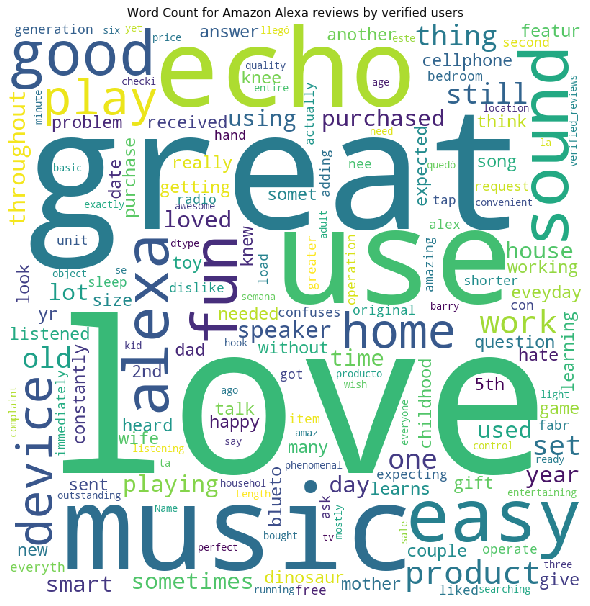

In [26]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color = "white",  
                min_font_size = 10).generate(str(alexa["verified_reviews"])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Count for Amazon Alexa reviews by verified users")
plt.show() 

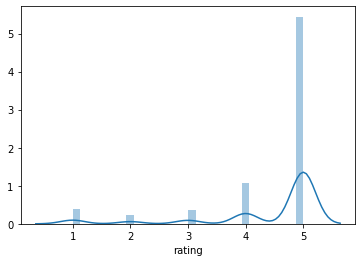

In [27]:
sns.distplot(alexa["rating"])

#### The ratings are highly skewed toward 5 stars!

#### All reviews with ratings of 1 star, 2 stars, and 3 stars are labelled as 0, while all reviews with ratings of 4 stars and 5 stars are labeled as 1.

In [28]:
alexa["label"] = [1 if x > 3 else 0 for x in alexa["rating"]]

In [29]:
#print(alexa.head(10))

#### Feature extraction is a process whereby we extract meaningful attributes from raw textual data that are fed into a statistical or ML algorithm. This process is also known as vectorization because the end result of this process is a set of numerical vectors. The step is needed because conventional algorithms work on numerical vectors and cannot work directly on raw text data.

#### TF-IDF 

In [31]:
alexa["verified_reviews"] = [" ".join(review) for review in alexa["verified_reviews"].values]

In [32]:
X = alexa["verified_reviews"]

In [33]:
y = alexa["label"]

In [34]:
vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1,1)) #using unigrams here.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [37]:
clf = MultinomialNB(alpha = .06) 

In [38]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test, y_pred)
print("The accuracy of Multinomial NB model is: {0}".format(score))
precision = precision_recall_fscore_support(y_test, y_pred, average='binary')
print("The precision, recall and fscore are as follows: {0}".format(precision))

The accuracy of Multinomial NB model is: 0.9015873015873016
The precision, recall and fscore are as follows: (0.9023569023569024, 0.9925925925925926, 0.945326278659612, None)


In [39]:
clf_bnb = BernoulliNB(alpha=.01)

In [40]:
clf_bnb.fit(X_train, y_train)
pred_bnb = clf_bnb.predict(X_test)
score_bnb = metrics.accuracy_score(y_test, pred_bnb)
print("The accuracy of Bernoulli NB model is: {0}".format(score_bnb))
precision_bnb = precision_recall_fscore_support(y_test, pred_bnb, average='binary')
print("The precision, recall and fscore are as follows: {0}".format(precision_bnb))

The accuracy of Bernoulli NB model is: 0.8888888888888888
The precision, recall and fscore are as follows: (0.8996598639455783, 0.9796296296296296, 0.9379432624113475, None)


In [41]:
clf_forest = RandomForestClassifier(criterion="entropy")

In [42]:
clf_forest.fit(X_train, y_train)
pred_forest = clf_forest.predict(X_test)
score_forest = metrics.accuracy_score(y_test, pred_forest)
print("The accuracy of Random Forest Classifier model is: {0}".format(score_forest))
precision_forest = precision_recall_fscore_support(y_test, pred_forest, average='binary')
print("The precision, recall and fscore are as follows: {0}".format(precision_forest))

/home/daminijain/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The accuracy of Random Forest Classifier model is: 0.9079365079365079
The precision, recall and fscore are as follows: (0.9140893470790378, 0.9851851851851852, 0.9483065953654188, None)


In [43]:
clf_svm = SGDClassifier()
clf_svm.fit(X_train, y_train)
pred_svm = clf_svm.predict(X_test)
score_svm = metrics.accuracy_score(y_test, pred_svm)
print("The accuracy of stochastic gradient descent model is: {0}".format(score_svm))
precision_svm = precision_recall_fscore_support(y_test, pred_svm, average='binary')
print("The precision, recall and fscore are as follows: {0}".format(precision_svm))

The accuracy of stochastic gradient descent model is: 0.9126984126984127
The precision, recall and fscore are as follows: (0.927689594356261, 0.9740740740740741, 0.950316169828365, None)


/home/daminijain/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [44]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
pred_lr = clf_lr.predict(X_test)
score_lr = metrics.accuracy_score(y_test, pred_lr)
print("The accuracy of Logistic Regression model is: {0}".format(score_lr))
precision_lr = precision_recall_fscore_support(y_test, pred_lr, average='binary')
print("The precision, recall and fscore are as follows: {0}".format(precision_lr))

/home/daminijain/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy of Logistic Regression model is: 0.861904761904762
The precision, recall and fscore are as follows: (0.861244019138756, 1.0, 0.9254498714652957, None)


In [45]:
clf_gbc = GradientBoostingClassifier(learning_rate=0.3)
clf_gbc.fit(X_train, y_train)
pred_gbc = clf_gbc.predict(X_test)
score_gbc = metrics.accuracy_score(y_test, pred_gbc)
print("The accuracy of Gradient Boosting Classifer model is: {0}".format(score_gbc))
precision_gbc = precision_recall_fscore_support(y_test, pred_gbc, average='binary')
print("The precision, recall and fscore are as follows: {0}".format(precision_gbc))

The accuracy of Gradient Boosting Classifer model is: 0.8984126984126984
The precision, recall and fscore are as follows: (0.916083916083916, 0.9703703703703703, 0.9424460431654677, None)
